In [24]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")


___
Enter Team Member Names here (double click to edit):

- Name 1: Allen Ansari
- Name 2: Chad Madding
- Name 3: Yongjun (Ian) Chu



________
<a id="top"></a>
# Live Session Assignment Two
In the following assignment you will be asked to fill in python code and derivations for a number of different problems. Please read all instructions carefully and turn in the rendered notebook (.ipynb file, remember to save it!!) or HTML of the rendered notebook before the end of class.

## Contents
* <a href="#Loading">Loading the Classification Data</a>
* <a href="#using_trees">Using Decision Trees - Gini</a>
* <a href="#entropy">Using Decision Trees - Entropy</a>
* <a href="#multi">Multi-way Splits</a>
* <a href="#sklearn">Decision Trees in Scikit-Learn</a>

________________________________________________________________________________________________________
<a id="Loading"></a>
<a href="#top">Back to Top</a>
## Loading the Classification Data
Please run the following code to read in the "digits" dataset from sklearn's data loading module. This is identical to the first in class assignment for loading the data into matrices. `ds.data` is a matrix of feature values and `ds.target` is a column vector of the class output (in our case, the hand written digit we want to classify). Each class is a number (0 through 9) that we want to classify as one of ten hand written digits. 



In [25]:
from __future__ import print_function
from sklearn.datasets import load_digits
import numpy as np

ds = load_digits()

# this holds the continuous feature data
print('features shape:', ds.data.shape) # there are 1797 instances and 64 features per instance
print('target shape:', ds.target.shape )
print('range of target:', np.min(ds.target),np.max(ds.target))

features shape: (1797, 64)
target shape: (1797,)
range of target: 0 9


Text(0.5,0.98,'Label is 7')

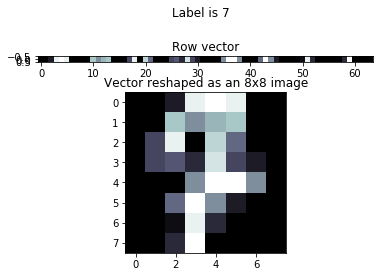

In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
 
#get the vector data from a random position
idx = np.random.randint(0,len(ds.target))
raw_row = ds.data[idx] # as a vector
img = ds.data[idx].reshape((8,8)) #reshaped to be an image 
 
#custom plotting tools 
gs = gridspec.GridSpec(4,2)
 
plt.subplot(gs[0,:]) #show vector
plt.imshow(np.matrix(raw_row), cmap=plt.cm.bone, interpolation='nearest')
plt.title('Row vector')

plt.subplot(gs[1:,:]) #show image
plt.imshow(img, cmap=plt.cm.bone, interpolation='nearest')
plt.title('Vector reshaped as an 8x8 image')

plt.suptitle('Label is %d'%(ds.target[idx]))


________________________________________________________________________________________________________
<a id="using_trees"></a>
<a href="#top">Back to Top</a>
## Using Decision Trees
In the videos, we talked about the splitting conditions for different attributes. Specifically, we discussed the number of ways in which it is possible to split a node, depending on the attribute types. To understand the possible splits, we need to understand the attributes. For the question below, you might find the description in the `ds['DESCR']` field to be useful. You can see the field using `print(ds['DESCR'])`

**Question 1:** For the digits dataset, what are the type(s) of the attributes? How many attributes are there? What do they represent?


In [26]:
## It is an Optical recognition of handwritten digits dataset.
print(ds['DESCR'])

##What are the type(s) of the attributes? 8x8 image of integer pixels in the range 0..16.
## How many attributes are there? 64
##What do they represent? hand-written digits: 10 classes where each class refers to a integer from 0 to 9.

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

___
## Using the gini coefficient
We talked about the gini index in the videos.  The gini coefficient for a **given split** is given by:
$$Gini=\sum_{t=1}^T \frac{n_t}{N}gini(t)$$
where $T$ is the total number of splits (2 for binary attributes), $n_t$ is the number of instances in node $t$ after splitting, and $N$ is the total number of instances in the parent node. $gini(t)$ is the **gini index for each individual node that is created by the split** and is given by:
$$gini(t)=1-\sum_{j=0}^{C-1} p(j|t)^2$$
where $C$ is the total number of possible classes and $p(j|t)$ is the probability of class $j$ in node $t$ (i.e., $n_j==$ the count of instances belonging to class $j$ in node $t$, normalized by the total number of instances in node $t$).
$$ p(j|t) = \frac{n_j}{n_t}$$ 

For the given dataset, $gini(t)$ has been programmed for you in the function `gini_index`. 

* `def gini_index(classes_in_split):`
 * To use the function, pass in a `numpy` array of the class labels for a node as (i.e., pass in the rows from `ds.target` that make up a node in the tree) and the gini will be returned for that node. 


In [27]:
# compute the gini of several examples for the starting dataset
# This function "gini_index" is written for you. Once you run this block, you 
#   will have access to the function for the notebook. You do not need to know 
#   how this function works--only what it returns 
# This function returns the gini index for an array of classes in a node.
def gini_index(classes_in_split):
    # pay no attention to this code in the function-- it just computes the gini for a given split 
    classes_in_split = np.reshape(classes_in_split,(len(classes_in_split),-1))
    unique_classes = np.unique(classes_in_split)
    gini = 1
    for c in unique_classes:
        gini -= (np.sum(classes_in_split==c) / float(len(classes_in_split)))**2
        
    return gini

In the example below, the function is used calculate the gini for splitting the dataset on feature 28, with value 2.5. In this example, we need to create two separate tree nodes: the first node has all the `ds.target` labels when feature 28 is greater than 2.5, the second node has all the rows from `ds.target` where feature 28 is less than 2.5. The steps are outlined below. **Read this carefully to understand what the code does below in the block following this.**
- Feature 28 is saved into a separate variable `feature28 = ds.data[:,28]`
- First all the target classes for the first node are calculated using `numpy` indexing `ds.target[feature28>2.5]` 
 - Note: this grabs all the rows in `ds.target` (the classes) which have feature 28 greater than 2.5 (similar to indexing in pandas)
- Second, those classes are passed into the function to get the gini for the right node in this split (i.e., feature 28 being greater than the threshold 2.5). 
 - `gini_r = gini_index(ds.target[feature28>2.5])`
- Third, the gini is calculated for the left node in the tree. This grabs only the rows in `ds.target` where feature 28 is less than 2.5.
     - `gini_l = gini_index(ds.target[feature28<=2.5])`
- Combining the gini indices is left as an exercise in the next section

In [28]:
#==========================Use the gini_index Example===============
# get the value for this feature as a column vector 
# (this is like grabbing one column of the record table)
feature28 = ds.data[:,28]

# if we split on the value of 2.5, then this is the gini for each resulting node:
gini_r = gini_index(ds.target[feature28>2.5]) # just like in pandas, we are sending in the rows where feature28>2.5
gini_l = gini_index(ds.target[feature28<=2.5]) # and sending the rows where feature28<=2.5

# compute gini example. This splits on attribute '28' with a value of 2.5
print('gini for right node of split:', gini_r)
print('gini for left node of split:', gini_l)

gini for right node of split: 0.8845857867667073
gini for left node of split: 0.7115407566535388


**Question 2:** Now, using the above values `gini_r` and `gini_l`. Calculate the combined Gini for the entire split. You will need to write the weighted summation (based upon the number of instances inside each node). To count the number of instances greater than a value using numpy, you can use broadcasting, which is a special way of indexing into a numpy array. For example, the code `some_array>5` will return a new numpy array of true/false elements. It is the same size as `some_array` and is marked true where the array is greater than `5`, and false otherwise. By taking the `sum` of this array, we can count how many times `some_array` is greater than `5`. 

`counts = sum(some_array>5)` 
 
You will need to use this syntax to count the values in each node as a result of splitting.  

In [29]:
## Count the number of instances
count_of_r = (sum(feature28>2.5))
count_of_l = (sum(feature28<=2.5))
length = float(len(ds.target))

# Calculate the combined Gini for the entire split
gini_combined = (count_of_r * gini_r + count_of_l * gini_l) / length

## Print out some of the information
print('The instances inside the right node:',count_of_r)
print('The instances inside the left node:',count_of_l)
print('The total gini of the split for a threshold of 2.5 is:',gini_combined)

The instances inside the right node: 1398
The instances inside the left node: 399
The total gini of the split for a threshold of 2.5 is: 0.8461634345045179


___
## Start of Live Session Coding

**Question 3:** Now we want to know which is a better split:
- `feature28` split on a value of `2.5`  
- `feature28` split on a value of `10`.  

Enter your code to find the total gini of splitting on the threshold of 10 and compare it to the total gini of splitting on threshold of 2.5 (for feature 28 only). According to gini, which threshold is better for spliting on feature 28, `threshold=2.5` or `threshold=10.0`?

In [36]:
# if we split on the value of 10, then this is the gini for each resulting node:
gini_r = gini_index(ds.target[feature28>10]) # just like in pandas, we are sending in the rows where feature28>10
gini_l = gini_index(ds.target[feature28<=10]) # and sending the rows where feature28<=10

## Count the number of instances
count_of_r = (sum(feature28>10))
count_of_l = (sum(feature28<=10))

# Calculate the combined Gini for the entire split
gini_combined = (count_of_r * gini_r + count_of_l * gini_l) / length

## Print out some of the information
print('Splitting on the threshold of 10:')
print('The instances inside the right node:',count_of_r)
print('The instances inside the left node:',count_of_l)
print('The total gini of the split for a threshold of 10 is:',gini_combined)
print('This is not better than the split on 2.5 (since the goal is to get lower gini).')

Splitting on the threshold of 10:
The instances inside the right node: 1043
The instances inside the left node: 754
The total gini of the split for a threshold of 10 is: 0.8636111743234274
This is not better than the split on 2.5 (since the goal is to get lower gini).


___
<a id="entropy"></a>
<a href="#top">Back to Top</a>
## Entropy based splitting
We discussed entropy as well in the video as another means of splitting. We calculated entropy for a node $t$ by:
$$ Entropy(t) = -\sum p(j|t) \log p(j|t) $$
where $p(j|t)$ is the same as above. To combine Entropy measures from a set of nodes, t = {1,...,T} we use: 
$$Entropy_{split}=\sum_{t=1}^T \frac{n_t}{N}Entropy(t)$$ 
where $n_t$ and $N$ are the same as defined above for the $Gini$. Information gain is calculated by subtracting the Entropy of the split from the Entropy of the parent node before splitting:
$$InfoGain = Entropy(p)-Entropy_{split}$$
where $p$ is the parent node before splitting. You are given an equation for calculating the $Entropy(t)$ of  node $t$. It works exactly like the `gini_index` function above, but is named `entropy_value` and returns the entropy for a node. You simply send in an array of the feature values for the node you want to calculate the entropy value for. 


In [37]:
def entropy_value(classes_in_split):
    # pay no attention to this code -- it just computes the gini for a given split 
    classes_in_split = np.reshape(classes_in_split,(len(classes_in_split),-1))
    unique_classes = np.unique(classes_in_split)
    ent = 0
    for c in unique_classes:
        p = (np.sum(classes_in_split==c) / float(len(classes_in_split)))
        ent += p * np.log(p)
        
    return -ent

In [38]:
ent_r = entropy_value(ds.target[feature28>2.5])
ent_l = entropy_value(ds.target[feature28<=2.5])

# compute entropy example. This splits on attribute '28' with a value of 2.5
print('entropy for right node of split:', ent_r)
print('entropy for left node of split:', ent_l)

entropy for right node of split: 2.1836975378213057
entropy for left node of split: 1.4898881412786364


___
**Question 4:** Calculate the **information gain** of the split when the threshold is 2.5 on `feature28`. What is the value of the information gain?

In [40]:
## Count the number of instances on a split of 2.5
count_of_r = (sum(feature28>2.5))
count_of_l = (sum(feature28<=2.5))

#print(count_of_r, count_of_l)

#Calculate the information gain (Information_Gain = total_entropy - Weighted_Entropy)
Weighted_Entropy = ((count_of_r*ent_r) + (count_of_l*ent_l)) / length
Information_Gain = entropy_value(ds.target) - Weighted_Entropy

# Enter your code here

print('The information gain of the split for threshold of 2.5:',Information_Gain)

The information gain of the split for threshold of 2.5: 0.27283285132716273


**Question 5:** What is the information gain if the threshold is 10.0 on `feature28`? According to information gain, is it better to split on a threshold of 2.5 or 10? Does entropy give the same decision as gini for this example?

In [41]:
## Count the number of instances on a split of 10
count_of_r = (sum(feature28>10))
count_of_l = (sum(feature28<=10))

# compute entropy with splits on attribute '28' with a value of 10
ent_r = entropy_value(ds.target[feature28>10])
ent_l = entropy_value(ds.target[feature28<=10])

print('entropy for right node of split:', ent_r)
print('entropy for left node of split:', ent_l)

#Calculate the information gain (Information_Gain = total_entropy - Weighted_Entropy)
Weighted_Entropy = ((count_of_r*ent_r) + (count_of_l*ent_l)) / length
Information_Gain = entropy_value(ds.target) - Weighted_Entropy

# Enter your code here

print('The information gain of the split for threshold of 10:',Information_Gain)
print('This is not better than the split on 2.5 (which is 0.27).')
print('Therefore, calcualtions based on entropy and gini coefficient yielded the same conclusion for this example.')

entropy for right node of split: 2.112391791714538
entropy for left node of split: 2.066003576622626
The information gain of the split for threshold of 10: 0.20955137704371163
This is not better than the split on 2.5 (which is 0.27).
Therefore, calcualtions based on entropy and gini coefficient yielded the same conclusion for this example.


___
<a id="multi"></a>
<a href="#top">Back to Top</a>
## Information gain and multi-way splitting
Now assume that we can use not just a binary split, but a three way split. 

**Question 6** What is the information gain if we split feature28 on two thesholds (three separate nodes corresponding to three branches from one node) 
- node left: `feature28<2.5`, 
- node middle: `2.5<=feature28<10`, and 
- node right: `10<=feature28`? 

Is the information gain better? 

***Note***: You can index into a `numpy` array for the middle node with the following notation: `some_array[(2.5<=feature28) & (feature28<10.0)]`

In [42]:
# Create three separate nodes corresponding to three branches from one node
ent_l = entropy_value(ds.target[feature28<2.5])
ent_m = entropy_value(ds.target[(feature28>=2.5) & (feature28<10)])
ent_r = entropy_value(ds.target[feature28>=10])

## Count the number of instances
count_of_l = (sum(feature28<2.5))
count_of_m = (sum((feature28>=2.5) & (feature28<10)))
count_of_r = (sum(feature28>=10))

#Calculate the information gain (Information_Gain = total_entropy - Weighted_Entropy)
Weighted_Entropy = ((count_of_l*ent_l) + (count_of_m*ent_m) + (count_of_r*ent_r)) / length
Information_Gain = entropy_value(ds.target) - Weighted_Entropy

# Enter your code here
print('The information gain of the three way split is:',Information_Gain)

The information gain of the three way split is: 0.3171890999123379


**Question 7**: Should we normalize the quantity that we just calculated if we want to compare it to the information gain of a binary split? Why or Why not?

A:  Yes. We should normalize the quantity that we just calculated if we want to compare it to the information gain of a binary split. 

Becasue the information gain described above is biased toward choosing features with a large number of values. The selection of a feature that is non-optimal for predication can result in overfitting. We have to normalize the information gain derived from a multiway split by the “intrinsic information” of a split, which is defined as the information need to determine the branch to which an instance belongs. This normalized information gain is called 'gain ratio'. Gain ratio takes into account the number and size of branches when choosing a feature. It tends to prefer unbalanced splits in which one partition is much smaller than the other.

___
<a id="sklearn"></a>
<a href="#top">Back to Top</a>
## Decision Trees in scikit-learn
Scikit-learn also has an implementation of decision trees. Its available here:
- http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

**Question 8**: What algorithm does scikit-learn use for creating decision trees (i.e., ID3, C4.5, C5.0, CART, MARS, CHAID, etc.)? 

In [18]:
print('According to https://scikit-learn.org/stable/modules/tree.html')
print('Scikit-learn uses an optimised version of the CART algorithm;')
print('however, scikit-learn implementation does not support categorical variables for now.')

According to https://scikit-learn.org/stable/modules/tree.html
Scikit-learn uses an optimised version of the CART algorithm;
however, scikit-learn implementation does not support categorical variables for now.


___
**Question 9**: Using the documentation, use scikit-learn to train a decision tree on the digits data. Calculate the accuracy on the training data. What is the accuracy? Did you expect the decision tree to have this kind of accuracy? Why or Why not?

In [52]:
# use scikit learn to train a decision tree
from sklearn.tree import DecisionTreeClassifier

# enter your code below here to train and predict on the same data
dtc = DecisionTreeClassifier()

#Build a decision tree classifier from the training set (X, y).
dtc.fit(ds.data, ds.target)
yhat = dtc.predict(ds.data)


from sklearn.metrics import accuracy_score 

# enter your code below here to calculate accuracy

accuracy = accuracy_score(ds.target, yhat)

print('accuracy:', accuracy)
print('We did not expect the accuracy to be one, but this is not unusual.')
print("Because in this case, we generated the decision tree from the train data and then used this decision tree to predict the same train data. High accuracy is clearly expected.")
print("On the other hand, there is a concern of potential overfitting going on here.")

accuracy: 1.0
We did not expect the accuracy to be one, but this is not unusual.
Because in this case, we generated the decision tree from the train data and then used this decision tree to predict the same train data. High accuracy is clearly expected.
On the other hand, there is a concern of potential overfitting going on here.


___
**Question 10**: Look at the other input parameters to the function `DecisionTreeClassifier` could any of them be used to help prevent the decision tree from overlearning on the data? 

Which variables might we use to control overfitting and how (explain why it might help to stop overfitting)?


A:  Yes. There are several input parameters in the DecisionTreeClassifier that might help in preventing overfiting. The website documantation may be found at:https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

max_depth - The maximum depth of the tree. If none, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit. The number of samples required to populate the tree doubles for each additional level the tree grows to. Therefore, we may use max_depth to control the size of the tree to prevent overfitting.

min_samples_split - minimum number of samples required to split an internal node.

min_samples_leaf - minimum number of samples required to be at a leaf node.

We use min_samples_split or min_samples_leaf to ensure that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will cause the tree to not fully learning the data. We can try min_samples_leaf = 5 as an initial value. If the sample size varies greatly, a float number can be used as percentage in these two parameters. While min_samples_split can create arbitrarily small leaves, min_samples_leaf guarantees that each leaf has a minimum size, avoiding low-variance, over-fit leaf nodes in regression problems. For classification with few classes, min_samples_leaf=1 is often the best choice. In summary, by systematically adjusting the settings of min_samples_split and min_samples_leaf, we may ruduce the possibility of overfitting the data with decision tree classifier. 


Reference: https://scikit-learn.org/stable/modules/tree.html

________________________________________________________________________________________________________

That's all! Please **upload your rendered notebook** and please include **team member names** in the notebook submission. Also please remember to save the notebook before uploading.